# Addition of two numbers using RNN

[Anyone can learn to code an LSTM-RNN in Python](https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/)

Addition can be treated as an RNN

## Problem definition

The goal is to minimise the errors

Dimensions are as follows:

\begin{matrix}
    h_i &:& n_h & \times & 1  \\
    x_i &:& 2 & \times & 1 \\
    W_{hh} &:& n_h & \times & n_h \\
    W_{yh} &:& 1 & \times & n_h \\
    W_{hx} &:& n_h & \times & 2 \\
    b_h &:& n_h & \times & 1 \\
    b_y &:& 1 & \times & 1
\end{matrix}

The optimisation problem is

\begin{align}
    \min && Obj \\
    over && W_{hh},& W_{hx}, W_{yh}, b_h, b_y \\
    s.t. && Obj & = \frac{1}{2} \sum_i err_i^2 \\ 
        && err_i & = y_i - y_{known\, i} \\
        && y_i & = \sigma ( z_i ) \\
        && z_i & = W_{yh} \, h_{i+1} + b_y \\
        && h_{i+1} & = \sigma ( v_i )\\
        && v_i & =  W_{hh} \, h_i + W_{hx} \, x_i + b_h \\
        && h_0 & = 0
\end{align}

# Implementations

## Tensorflow implementation

[RNN with tensorflow](https://www.tensorflow.org/versions/r0.11/tutorials/recurrent/index.html)


https://github.com/nlintz/TensorFlow-Tutorials/blob/master/07_lstm.py

https://www.tensorflow.org/versions/r0.9/api_docs/python/nn.html#rnn

http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter

In [1]:
%matplotlib inline
import ipywidgets as ipyw
from importlib import reload
import tensorflow as tf
import utils_tf

In [2]:
n_hidden = 4
n_epochs = int(1e4)
alpha_param = .5
n_bits = 8

### Helper functions

In [3]:
# This uses the `rnn_cell` and `rnn` functionality provided by `tensorflow`.

def get_digits(x_in, min_digits=0):
    in_shape = [x for x in np.shape(x_in)]
    x_in = np.array(x_in).flatten()
    n_nums = len(x_in)
    n_digits = np.maximum(len('{}'.format(x_in.max())), min_digits)
    x_out = np.zeros([n_nums, 10, n_digits])
    for i_x, x_ in enumerate(x_in):
        x_str = '{}'.format(x_).zfill(n_digits)
        for i_dig, x_dig in enumerate(x_str):
            x_out[i_x, int(x_dig), i_dig] = 1.
    return x_out.reshape(in_shape + [10, n_digits])

def get_num(x_in):
    '''(10 x digits)'''
    n_system = x_in.shape[0]
    n_digits = x_in.shape[1]
    x_out = x_in * (n_system**np.arange(n_digits)[::-1])
    x_out *= np.arange(n_system)[:, None]
    return x_out.sum()

#### Input parameters

In [4]:
numerical_base = 10
n_digits = 2
n_hidden = numerical_base**2+30
n_epochs = int(1e5)

## Hard coded network

In [26]:
# Network with parameters initialised in order to memorise how to add

class hardCodedRnn(object):
    def __init__(self):
        self.W_hx = np.zeros([100, 20])
        self.W_yh = np.zeros([10, 100])
        for ii in range(10):
            for jj in range(10):
                self.W_hx[ii + 10*jj, ii] = 10.
                self.W_hx[ii + 10*jj, 10+jj] = 10.
                self.W_yh[(ii+jj)%10, ii + 10*jj] = 10.
        self.b_y = -5
        self.b_h = -15
        self.sig = lambda x : 1 / (1 + np.exp(-x))

    def calc(self, x1, x2):
        x = get_digits([x1%10, x2%10]).reshape([20, 1])
        h = self.sig(self.W_hx @ x + self.b_h)
        y = self.sig(self.W_yh @ h + self.b_y)
        return get_num(y>0.5)

h_rnn = hardCodedRnn()

In [6]:
for ii in range(10):
    for jj in range(10):
        if h_rnn.calc(ii, jj) != (ii+jj)%10:
            print(ii, jj)

## Tensorflow implementation

In [7]:
batch_size = 100

tf.reset_default_graph()
rnn = tf.nn.rnn_cell.BasicRNNCell(n_hidden, 
                                  activation=tf.sigmoid)
x = tf.placeholder(tf.float32, shape=[2*numerical_base, n_digits, batch_size], name='x')
y = tf.placeholder(tf.float32, shape=[1*numerical_base, n_digits, batch_size], name='y')
xt = tf.transpose(x)#, perm=[1, 2, 0])

x_split = [x_temp[:,0,:] for x_temp in tf.split(1, n_digits, xt)[::-1]]
h_list, _ = tf.nn.rnn(rnn, x_split, dtype=tf.float32)
h = tf.transpose(tf.concat(0, h_list[::-1]))
W_yh = tf.Variable(tf.random_normal([10, n_hidden], 
                                    dtype=tf.float32), name='W_yh')
b_y = tf.Variable(tf.random_normal([1, 1], dtype=tf.float32), name='b_y')
y_est = tf.reshape(tf.sigmoid(tf.matmul(W_yh, h) + b_y), y.get_shape())
# l1 = tf.contrib.layers.l1_regularizer(tf.constant(0.1))
tf_vars = tf.trainable_variables()
cost = tf.reduce_mean((y_est - y)**2, name='cost')
train_op = tf.train.GradientDescentOptimizer(0.1).minimize(
    cost, name='train')

In [8]:
sess = tf.Session()
tf.initialize_all_variables().run(session=sess)

In [9]:
n_epochs = int(1e6)

f = ipyw.FloatProgress(min=0, max=n_epochs)
display(f)
err = []
np.random.seed(100)
i_epoch = 0
for i_epoch in range(n_epochs):
    x_rand = np.random.randint(0, 10, 
        size=[2, batch_size])
    x_dig = get_digits(x_rand, n_digits)
    x_dig = x_dig.transpose([0, 2, 3, 1])
    x_dig = x_dig.reshape([-1, n_digits, batch_size])
    y_rand = x_rand.sum(0)
    y_dig = get_digits(y_rand, n_digits).transpose([1, 2, 0])
    if i_epoch%100 == 0:
        f.value = i_epoch
        err.append(sess.run(cost,
            feed_dict={x:x_dig, y:y_dig}))
    sess.run(train_op, feed_dict={x:x_dig, y:y_dig})

In [29]:
@ipyw.interact(ii='1')
def fun(ii='1'):
    ii = int(ii)
    print(get_num(x_dig[:10, :, ii]), get_num(x_dig[10:, :, ii]))
    print(get_num(y_dig[:,:,ii]))
    y_dig_est = np.round(sess.run(y_est, feed_dict={x:x_dig}), 1)[:,:,ii]
    print(get_num(np.round(y_dig_est)))
    print(np.round(sess.run(y_est, feed_dict={x:x_dig}), 1)[:,:,ii])
    print(y_dig[:,:,ii])

4.0 7.0
11.0
11.0
[[ 0.          0.1       ]
 [ 1.          0.80000001]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.1       ]]
[[ 0.  0.]
 [ 1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


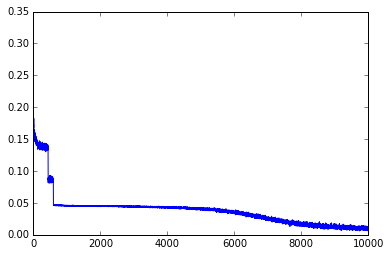

In [10]:
plt.plot(err)

In [24]:
def check_res(x1, x2):
    x_digits = get_digits([x1, x2], 1)
    y_digits = sess.run(y_est, feed_dict={x:x_digits})
    return get_num(y_digits)